In [16]:
'''
Krotov Algorithm for Quantum gate Implementation
Written By Bilal Riaz


'''
import matplotlib
import scipy.stats
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
import scipy.linalg as LA
from scipy.integrate import ode


class Krotov:
    def __init__(self,J,lambda_1,ti,tf,steps):
        self.J = float(J)
        self.lambda_1 = float(lambda_1)
        self.ti = ti
        self.tf = tf
        self.steps = steps
        self.t = np.linspace(ti,tf,steps)

        self.dt = self.t[1] - self.t[0]
        self.sX = np.array([[0, 1], [1, 0]], dtype = 'complex64')
        self.sY = np.array([[0, -1j], [1j, 0]], dtype = 'complex64')
        self.sZ = np.array([[1, 0], [0, -1]], dtype = 'complex64')
        self.I = np.array(np.identity(2), dtype = 'complex64')

        self.sZZ = np.kron(self.sZ, self.sZ)
        self.sIY = np.kron(self.I, self.sY)
        self.sYI = np.kron(self.sY, self.I)
        self.sIZ = np.kron(self.I, self.sZ)
        self.sZI = np.kron(self.sZ, self.I)

        self.delta1 = 0
        self.alpha1 = 1
        self.delta2 = 1.9
        self.alpha2 = 0.3
        self.delta3 = 1.6
        self.alpha3 = 0.4
        self.delta4 = 1.6
        self.alpha4 = 0.4

       # seed is given values for better debugging and Design Purposes
        #rnd.seed(2)
        
        omega = 10;
        
        # Controls
        self.EYI = np.zeros((self.steps,))
        #self.EYI_tilde = self.EYI
        self.EYI_tilde = np.zeros((self.steps,))
        self.EIY = 10 *rnd.rand(self.steps,) -5
        #self.EIY_tilde = self.EIY
        self.EIY_tilde = np.zeros((self.steps,))
        self.EZI = 10 *rnd.rand(self.steps,) -5
        #self.EZI_tilde = self.EZI
        self.EZI_tilde = np.zeros((self.steps,))
        self.EIZ = 10 *rnd.rand(self.steps,) -5
        #self.EIZ_tilde = self.EIZ
        self.EIZ_tilde = np.zeros((self.steps,))

        self.Ui = np.identity(4, dtype = 'complex128')
        self.UT = np.exp(-1j * np.pi/4)*np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]], dtype = 'complex128')

        self.U = np.zeros([self.steps, 4, 4], dtype = 'complex128')
        self.B = np.zeros([self.steps, 4, 4], dtype = 'complex128')

        self.U[0] = np.identity(4, dtype = 'complex128')
        self.B[steps - 1] = self.UT.T.conj()

        self. Ho = self.J * self.sZZ

    def Hc(self, t_index):
        t = t_index
        return (self.EYI[t] * self.sYI + self.EIY[t] * self.sIY + self.EZI[t] * self.sZI + self.EIZ[t] * self.sIZ )

    def Hc_tilde(self, t_index):
        t = t_index
        return (self.EYI_tilde[t] * self.sYI + self.EIY_tilde[t] * self.sIY + self.EZI_tilde[t] * self.sZI + self.EIZ_tilde[t]* self.sIZ)

    def H(self, t_index):
        t = t_index
        return (self.Ho + self.Hc(t))

    def H_tilde(self, t_index):
        t = t_index
        return (self. Ho + self.Hc_tilde(t))

    def update_U (self, t_index):
        t = t_index
        self.U[t+1] = np.dot(LA.expm(-1j * self.H(t) * self.dt), self.U[t])

    def update_B (self, t_index):
        t = t_index
        self.B[t-1] = np.dot( self.B[t], LA.expm(-1j * self.H_tilde(t) * self.dt))

    def update_E(self, t_index):
        t=t_index

        EIYpart1 = (1-self.delta2) * self.EIY_tilde[t-1]
        EIYpart2 = -self.delta2 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sIY, self.U[t]) ) ) )/ self.alpha2
        self.EIY[t] = -(EIYpart1 + EIYpart2)

        EZIpart1 = (1-self.delta3) * self.EZI_tilde[t-1]
        EZIpart2 = -self.delta3 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sZI, self.U[t]) ) ) )/ self.alpha3
        self.EZI[t] = -(EZIpart1 + EZIpart2)

        EIZpart1 = (1-self.delta4) * self.EIZ_tilde[t-1]
        EIZpart2 = -self.delta4 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sIZ, self.U[t]) ) ) )/ self.alpha4
        self.EIZ[t] = -(EIZpart1 + EIZpart2)


    def update_E_tilde(self,t_index):
        t=t_index

        EIYpart1 = (1-self.delta2) * self.EIY[t]
        EIYpart2 = -self.delta2 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sIY, self.U[t]) ) ) )/ self.alpha2
        self.EIY_tilde[t] = -(EIYpart1 + EIYpart2)

        EZIpart1 = (1-self.delta3) * self.EZI[t]
        EZIpart2 = -self.delta3 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sZI, self.U[t]) ) ) )/ self.alpha3
        self.EZI_tilde[t] = -(EZIpart1 + EZIpart2)

        EIZpart1 = (1-self.delta4) * self.EIZ[t]
        EIZpart2 = -self.delta4 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sIZ, self.U[t]) ) ) )/ self.alpha4
        self.EIZ_tilde[t] = -(EIZpart1 + EIZpart2)

    def evolution_U(self,string='not initial'):
        if string == 'initial':
            for t in range(0,self.steps-1):
                self.update_U(t)
        else:
            for t in range(0,self.steps-1):
                self.update_E(t)
                self.update_U(t)
            t = self.steps-1
            self.update_E(t)

    def evolution_B(self):
        for t in range(self.steps-1,0,-1):
            self.update_E_tilde(t)
            self.update_B(t)
        t = 0
        self.update_E_tilde(t)

    def O(self,step):
        t = step
        return( np.dot(self.UT.conj().T, self.U[t] ))
    # Some methods might seem redundant but they are maintained to solve complicated optimal control problems in future
    # Better Structured Toolboxes can give 
    def Overlap(self, t_index ):
        t = t_index
        return( np.abs(np.trace(self.O(t))))

    def distance(self,t_index):
        t= t_index
        return(LA.norm(self.UT - self.U[t], 'fro'))

    def Run_Krotov(self, num_iter):
        T = self.steps-1
        self.evolution_U('initial')
        self.overlap = np.zeros([num_iter,1], dtype = 'float64')
        self.dis = np.zeros([num_iter,1], dtype = 'float64')

        for i in range(0,num_iter):
            print ("Cycle : " + str(i))
            #print (str(self.overlap[i]))
            self.B[T] = self.UT.conj().T
            self.evolution_B()
            self.evolution_U()
            self.overlap[i] = self.Overlap(T)
            self.dis[i] = self.distance(T)


Cycle : 0
Cycle : 1
Cycle : 2
Cycle : 3
Cycle : 4
Cycle : 5
Cycle : 6
Cycle : 7
Cycle : 8
Cycle : 9
Cycle : 10
Cycle : 11
Cycle : 12
Cycle : 13
Cycle : 14
Cycle : 15
Cycle : 16
Cycle : 17
Cycle : 18
Cycle : 19
Cycle : 20
Cycle : 21
Cycle : 22
Cycle : 23
Cycle : 24
Cycle : 25
Cycle : 26
Cycle : 27
Cycle : 28
Cycle : 29
Cycle : 30
Cycle : 31
Cycle : 32
Cycle : 33
Cycle : 34
Cycle : 35
Cycle : 36
Cycle : 37
Cycle : 38
Cycle : 39
Cycle : 40
Cycle : 41
Cycle : 42
Cycle : 43
Cycle : 44
Cycle : 45
Cycle : 46
Cycle : 47
Cycle : 48
Cycle : 49
Cycle : 50
Cycle : 51
Cycle : 52
Cycle : 53
Cycle : 54
Cycle : 55
Cycle : 56
Cycle : 57
Cycle : 58
Cycle : 59
Cycle : 60
Cycle : 61
Cycle : 62
Cycle : 63
Cycle : 64
Cycle : 65
Cycle : 66
Cycle : 67
Cycle : 68
Cycle : 69
Cycle : 70
Cycle : 71
Cycle : 72
Cycle : 73
Cycle : 74
Cycle : 75
Cycle : 76
Cycle : 77
Cycle : 78
Cycle : 79
Cycle : 80
Cycle : 81
Cycle : 82
Cycle : 83
Cycle : 84
Cycle : 85
Cycle : 86
Cycle : 87
Cycle : 88
Cycle : 89
Cycle : 90
Cycle : 9

Cycle : 692
Cycle : 693
Cycle : 694
Cycle : 695
Cycle : 696
Cycle : 697
Cycle : 698
Cycle : 699
Cycle : 700
Cycle : 701
Cycle : 702
Cycle : 703
Cycle : 704
Cycle : 705
Cycle : 706
Cycle : 707
Cycle : 708
Cycle : 709
Cycle : 710
Cycle : 711
Cycle : 712
Cycle : 713
Cycle : 714
Cycle : 715
Cycle : 716
Cycle : 717
Cycle : 718
Cycle : 719
Cycle : 720
Cycle : 721
Cycle : 722
Cycle : 723
Cycle : 724
Cycle : 725
Cycle : 726
Cycle : 727
Cycle : 728
Cycle : 729
Cycle : 730
Cycle : 731
Cycle : 732
Cycle : 733
Cycle : 734
Cycle : 735
Cycle : 736
Cycle : 737
Cycle : 738
Cycle : 739
Cycle : 740
Cycle : 741
Cycle : 742
Cycle : 743
Cycle : 744
Cycle : 745
Cycle : 746
Cycle : 747
Cycle : 748
Cycle : 749
Cycle : 750
Cycle : 751
Cycle : 752
Cycle : 753
Cycle : 754
Cycle : 755
Cycle : 756
Cycle : 757
Cycle : 758
Cycle : 759
Cycle : 760
Cycle : 761
Cycle : 762
Cycle : 763
Cycle : 764
Cycle : 765
Cycle : 766
Cycle : 767
Cycle : 768
Cycle : 769
Cycle : 770
Cycle : 771
Cycle : 772
Cycle : 773
Cycle : 774
Cycl

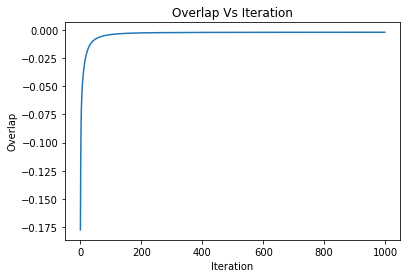

In [17]:
if __name__ == '__main__':
    # INTITIALIZE : J,lambda_1,ti,tf,steps
    k = Krotov(0.1, 5e-1, 0, 8,5000)
    k.Run_Krotov(1000)
    s = Krotov(0.1, 5e-1 ,0, 8,5000)
    s.Run_Krotov(0)
            
    plt.figure(1)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.plot(np.log(np.abs(k.overlap)/4))
    plt.show()


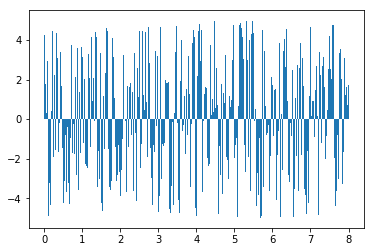

In [21]:
plt.figure(2)
plt.bar(s.t,s.EIZ,linewidth = 0.01, width = s.dt)
plt.show()

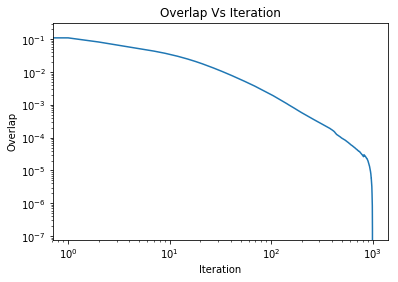

In [22]:
plt.figure(3)
plt.title('Overlap Vs Iteration')
plt.ylabel('Overlap')
plt.xlabel('Iteration')
plt.loglog(1-np.abs(k.overlap)/max(np.abs(k.overlap)))
plt.show()

In [23]:
# Now exporting variables to matlab to have comparsion with GRAPE and other standard Implementations



import scipy.io as sio


Krotov_data = { };
Krotov_data['J'] = k.J
Krotov_data['lambda_1'] = k.lambda_1 
Krotov_data['ti'] = k.ti
Krotov_data['tf'] = k.tf
Krotov_data['steps'] = k.steps
Krotov_data['t'] = k.t
Krotov_data['dt'] = k.dt

Krotov_data['U'] = k.U
Krotov_data['B'] = k.B

Krotov_data['EYI'] = k.EYI;
Krotov_data['EIY'] = k.EIY;
Krotov_data['EIZ'] = k.EIZ;
Krotov_data['EZI'] = k.EZI;

Krotov_data['EYI_tilde'] = k.EYI_tilde;
Krotov_data['EIY_tilde'] = k.EIY_tilde;
Krotov_data['EIZ_tilde'] = k.EIZ_tilde;
Krotov_data['EZI_tilde'] = k.EZI_tilde;

Krotov_data['dis'] = k.dis;
Krotov_data['overlap'] = k.overlap;


Krotov_data['sI'] = k.I;
Krotov_data['sX'] = k.sX;
Krotov_data['sY'] = k.sY;
Krotov_data['sZ'] = k.sZ;
Krotov_data['sIY'] = k.sIY;
Krotov_data['sYI'] = k.sYI;
Krotov_data['sZI'] = k.sZI;
Krotov_data['sIZ'] = k.sIZ;

Krotov_data['sIZ'] = k.delta1
Krotov_data['sIZ'] = k.alpha1 
Krotov_data['sIZ'] = k.delta2 
Krotov_data['alpha2'] = k.alpha2
Krotov_data['delta3'] = k.delta3
Krotov_data['alpha3'] = k.alpha3
Krotov_data['delta4'] = k.delta4
Krotov_data['alpha4'] = k.alpha4 
            
            
            
sio.savemat('Krotov_file2', Krotov_data)



